# Bike sharing demand in Washington, D.C.

https://www.kaggle.com/c/bike-sharing-demand/data


- hourly rental data spanning two years
- the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month
- goal: predict the total **count** of bikes rented during each hour covered by the test set, using only information available prior to the rental period
- evaluation based on [Root Mean Squared Logarithmic Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html)

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
train = pd.read_csv('train.csv', parse_dates=[0])
test = pd.read_csv('test.csv', parse_dates=[0])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
def create_date_features(df):
    x = df['datetime']
    return pd.DataFrame({
        'month': x.dt.month,
        'hour': x.dt.hour,
        'week': x.dt.isocalendar().week,
        'weekday': x.dt.weekday
    })

In [4]:
datetime_pipeline = make_pipeline(
    FunctionTransformer(create_date_features, validate=False),
    OneHotEncoder(handle_unknown='ignore')
)


transformer = make_column_transformer(
    (datetime_pipeline, ['datetime']),
    (StandardScaler(), ['temp', 'atemp', 'humidity', 'windspeed']),         
    (OneHotEncoder(handle_unknown='ignore'), ['season', 'weather']),
    ('passthrough', ['workingday', 'holiday'])
)

In [5]:
model_pipeline = make_pipeline(
    transformer, 
    PoissonRegressor(max_iter=1000)
)

In [6]:
# hyperparameter optimization
param_grid = {
    'poissonregressor__alpha': [0.001, 0.01, 0.1, 1, 10, 20, 30, 40]
}

In [7]:
X_train = train.drop(['casual','registered', 'count'], axis=1)
y_train = train['count']

In [8]:
def rmsle(y, y_pred):   
    """Root Mean Square Log (better for count values over multiple decimal places)"""
    # set negative to zero
    y_pred[y_pred < 0] = 0
        
    return np.sqrt(metrics.mean_squared_log_error(y, y_pred))

neg_rmsle_score = metrics.make_scorer(rmsle, greater_is_better=False)

In [9]:
cv = GridSearchCV(
    model_pipeline, 
    param_grid, 
    return_train_score=True, 
    scoring=neg_rmsle_score, 
    cv=5, 
    n_jobs=4, 
    refit=True,
    verbose=1
)
cv.fit(X_train, y_train)
cv_res = pd.DataFrame(cv.cv_results_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [10]:
cv_res[[
    'param_poissonregressor__alpha',
    'mean_train_score', 
    'mean_test_score'
]].abs()

,param_poissonregressor__alpha,mean_train_score,mean_test_score
0,0.001,0.649248,0.784182
1,0.01,0.651856,0.785486
2,0.1,0.683018,0.805856
3,1,0.870597,0.954479
4,10,1.18241,1.23024
5,20,1.25658,1.2982
6,30,1.29313,1.3319
7,40,1.31642,1.35341


<AxesSubplot:xlabel='param_poissonregressor__alpha'>

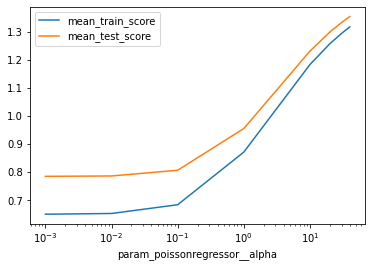

In [11]:
cv_res[[
    'param_poissonregressor__alpha',
    'mean_train_score', 
    'mean_test_score'
]].abs().plot(x='param_poissonregressor__alpha', logx=True)

In [12]:
cv.best_params_

{'poissonregressor__alpha': 0.001}

In [13]:
y_pred = cv.best_estimator_.predict(test)
y_pred[y_pred < 0] = 0
assert all(y_pred >= 0)